In [6]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
DB_PATH = "../datasets/CCSMLDatabase.db"
TABLE = "master"

conn = sqlite3.connect(DB_PATH)
df = pd.read_sql_query(
    f"SELECT * FROM master",
    conn,
)
conn.close()

np.shape(df)

(69868, 13)

Global Plotting Formatting

In [8]:
# Global style settings
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"], # Standard crisp fonts
    "axes.linewidth": 1.5,               # Thicker axis lines
    "axes.spines.top": False,            # Remove top spine
    "axes.spines.right": False,          # Remove right spine
    "xtick.major.width": 1.5,            # Match tick thickness to axis
    "ytick.major.width": 1.5,
    "xtick.direction": "out",            # Ticks point outside
    "ytick.direction": "out",
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.labelweight": "normal",
})

Plotting Out m/z against CCS For All Data Points In The Dataset. Colored By Subclass

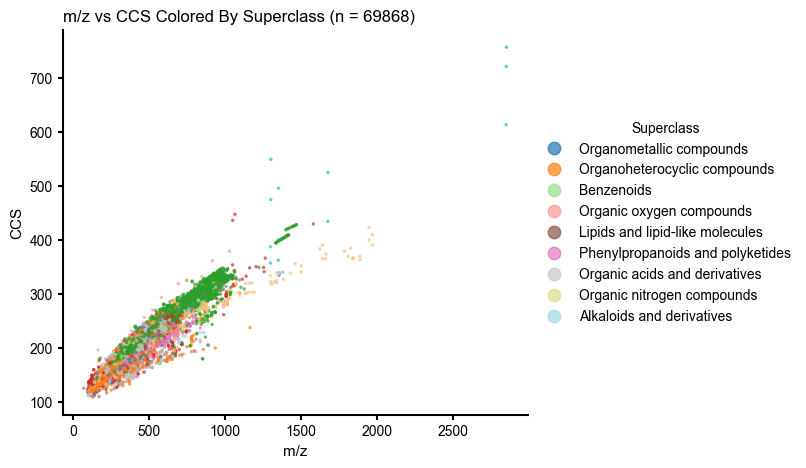

In [10]:
# Make a new column grouping nulls as 'Other'
superclass_grouped = df['superclass'].fillna('Other')

codes, uniques = pd.factorize(superclass_grouped)
fig, ax = plt.subplots(figsize=(6, 5))
scatter = ax.scatter(
    df['mass'], df['ccs'],
    c=codes,
    cmap='tab20',
    alpha=0.7,
    s=6,
    edgecolors='none'  # Removes outlines for cleaner look at high density
)
ax.set_xlabel('m/z')
ax.set_ylabel('CCS')
ax.set_title(f'm/z vs CCS Colored By Superclass (n = {len(df)})', loc='left')

legend = ax.legend(
    *scatter.legend_elements(),
    title="Superclass",
    loc="center left",
    bbox_to_anchor=(1, 0.5),  # Moves legend outside the plot
    markerscale=1.5,
    frameon=False,
)

# Update legend labels to actual names (now includes 'Other' for nulls)
for i, text in enumerate(legend.get_texts()):
    text.set_text(uniques[i])

# plt.savefig('mz_ccs_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

Plotting Out m/z against CCS For All Data Points In The Dataset. Colored By Chem Labs

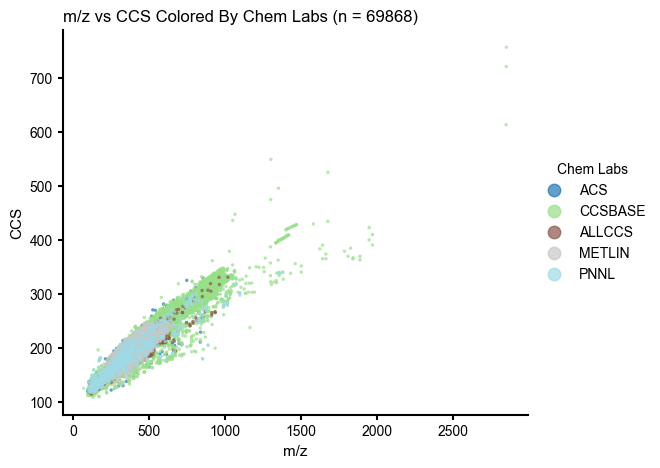

In [11]:
# Make a new column grouping nulls as 'Other'
# group it by tag/lab
tag_grouped = df['tag'].fillna('Other')

codes, uniques = pd.factorize(tag_grouped)

fig, ax = plt.subplots(figsize=(6, 5))
scatter = ax.scatter(
    df['mass'], df['ccs'],
    c=codes,
    cmap='tab20',
    alpha=0.7,
    s=6,
    edgecolors='none'  # Removes outlines for cleaner look at high density
)
ax.set_xlabel('m/z')
ax.set_ylabel('CCS')
ax.set_title(f'm/z vs CCS Colored By Chem Labs (n = {len(df)})', loc='left')

legend = ax.legend(
    *scatter.legend_elements(),
    title="Chem Labs",
    loc="center left",
    bbox_to_anchor=(1, 0.5),  # Moves legend outside the plot
    markerscale=1.5,
    frameon=False,
)

# Update legend labels to actual names (now includes 'Other' for nulls)
for i, text in enumerate(legend.get_texts()):
    text.set_text(uniques[i])
plt.show()

Database Entry Breakdown By Lab

<BarContainer object of 5 artists>

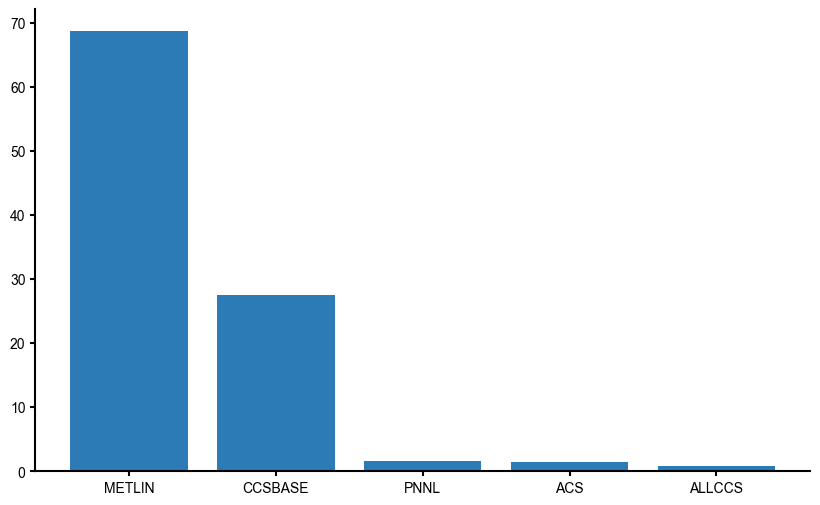

In [ ]:
total_n = len(df)

# Group by 'tag' and count entries
tag_counts = df['tag'].value_counts(dropna=False)

# Calculate percentage of total entries for each tag
tag_percents = (tag_counts / total_n) * 100

# Create a bar plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(tag_counts.index, tag_percents, color='#2c7bb6')
ax.set_ylabel('Percent of dataset (%)')
ax.set_xlabel('Chem Lab')
ax.set_title('Database Entry Breakdown By Lab')
ax.tick_params(axis='x', rotation=45)
plt.show()



Superclass, Subclass, and Adduct Breakdown

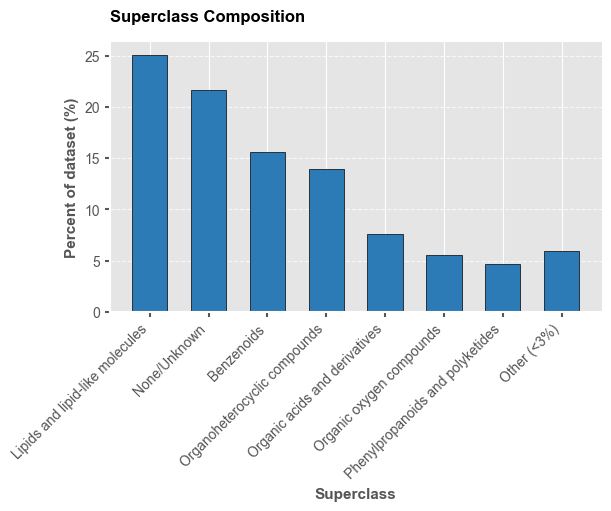

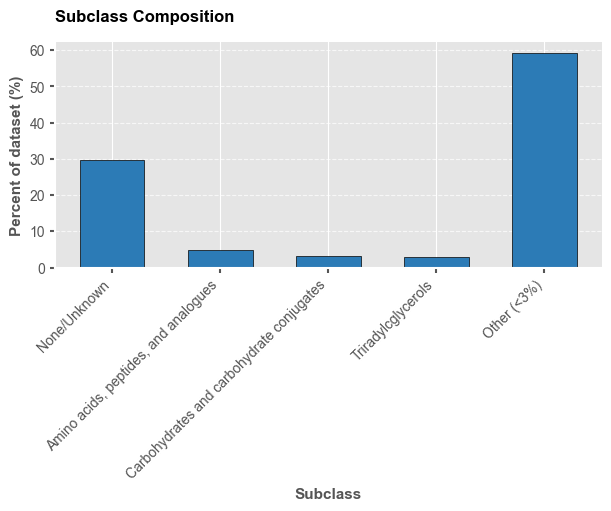

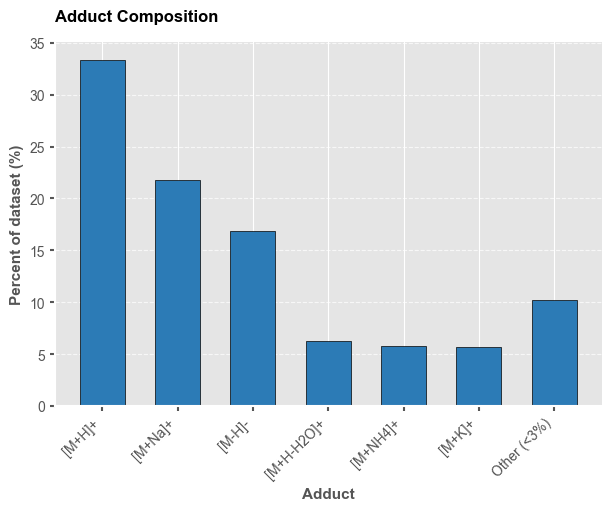

In [ ]:
fields = [('superclass', 'Superclass'), ('subclass', 'Subclass'), ('adduct', 'Adduct')]

for col, display_name in fields:
    counts = df[col].value_counts(dropna=False)
    perc = (counts / len(df)) * 100

    # Group anything with less than 3% into 'Other'
    mask = perc < 3
    main_perc = perc[~mask] 
    other_sum = perc[mask].sum()
    
    # Handle Labels: Ensure NaN is a string and readable
    labels = [str(lbl) if pd.notna(lbl) else 'None/Unknown' for lbl in main_perc.index]
    values = main_perc.values.tolist()
    
    if other_sum > 0:
        values.append(other_sum)
        labels.append('Other (<3%)')

    fig, ax = plt.subplots(figsize=(max(6, 0.5 * len(labels)), 5), constrained_layout=True)

    ax.bar(labels, values, color='#2c7bb6', width=0.6, edgecolor='black', linewidth=0.5)
    ax.set_ylabel('Percent of dataset (%)', fontweight='bold')
    ax.set_xlabel(display_name, fontweight='bold')
    ax.set_title(f'{display_name} Composition', loc='left', fontsize=12, fontweight='bold', pad=15)
    
    ax.set_xticks(range(len(labels))) # Explicitly set tick positions
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.yaxis.grid(True, linestyle='--', alpha=0.7, zorder=0)
    ax.set_axisbelow(True) # Ensure grid is behind bars

    plt.show()

Count of CCS Types in the database

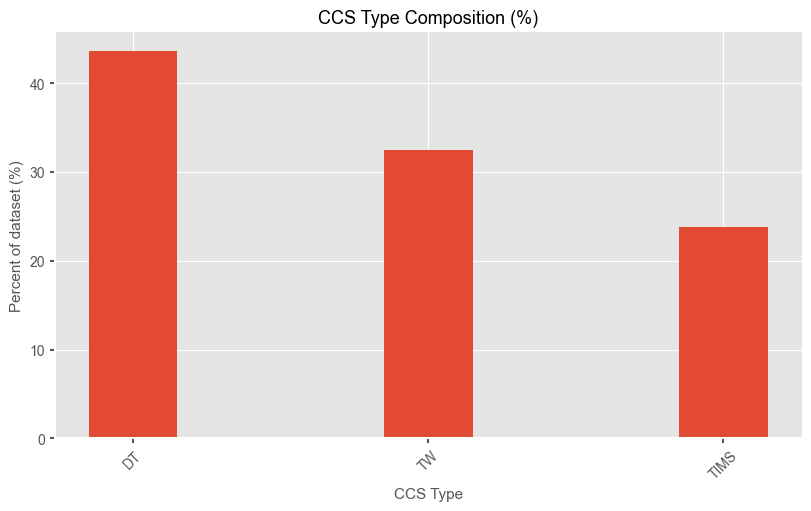

In [ ]:
ccs_type_counts = df["ccs_type"].value_counts(dropna=False)
labels = ccs_type_counts.index.tolist()
perc_values = (ccs_type_counts / len(df)) * 100

fig, ax = plt.subplots(figsize=(max(8, 0.4 * len(labels)), 5), constrained_layout=True)
ax.bar(labels, perc_values, width=0.3)
ax.set_ylabel('Percent of dataset (%)')
ax.set_xlabel('CCS Type')
ax.set_title('CCS Type Composition (%)')
ax.tick_params(axis='x', rotation=45) 

plt.show()

PCA/UMAP Analysis

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


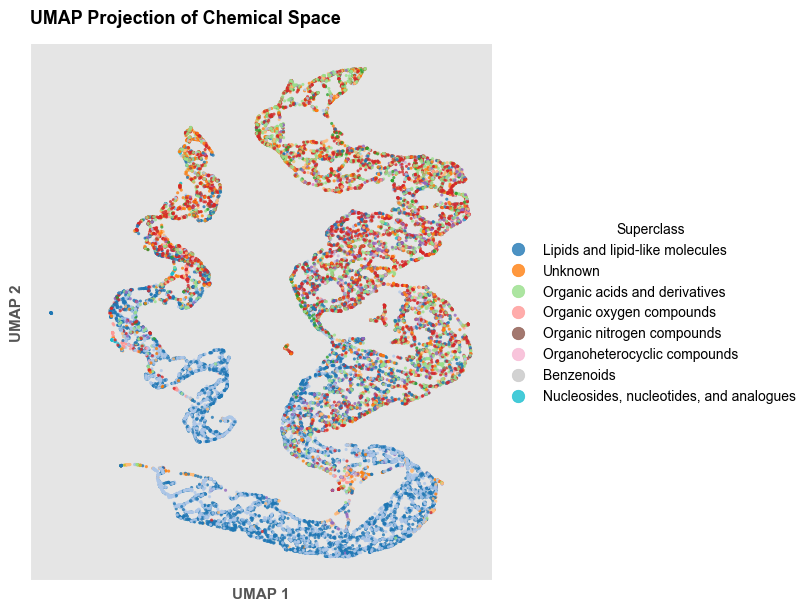

In [108]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

# Assuming 'superclass' and other metadata are columns to exclude from the math
features = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[features].values

# 2. Pipeline: Scale -> PCA -> UMAP
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=min(50, X.shape[1]))
X_pca = pca.fit_transform(X_scaled)

# UMAP projection
reducer = umap.UMAP(
    n_neighbors=15, 
    min_dist=0.1, 
    metric='euclidean', 
    random_state=42
)
embedding = reducer.fit_transform(X_pca)

codes, uniques = pd.factorize(df['superclass'].fillna('Unknown'))

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
scatter = ax.scatter(
    embedding[:, 0], 
    embedding[:, 1], 
    c=codes, 
    cmap='tab20', 
    s=5, 
    alpha=0.8,
    edgecolors='none'
)

legend = ax.legend(
    *scatter.legend_elements(),
    title="Superclass",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    markerscale=1.5
)
for i, text in enumerate(legend.get_texts()):
    text.set_text(uniques[i])

ax.set_title("UMAP Projection of Chemical Space", loc='left', fontweight='bold', pad=15)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP 1', fontweight='bold')
ax.set_ylabel('UMAP 2', fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

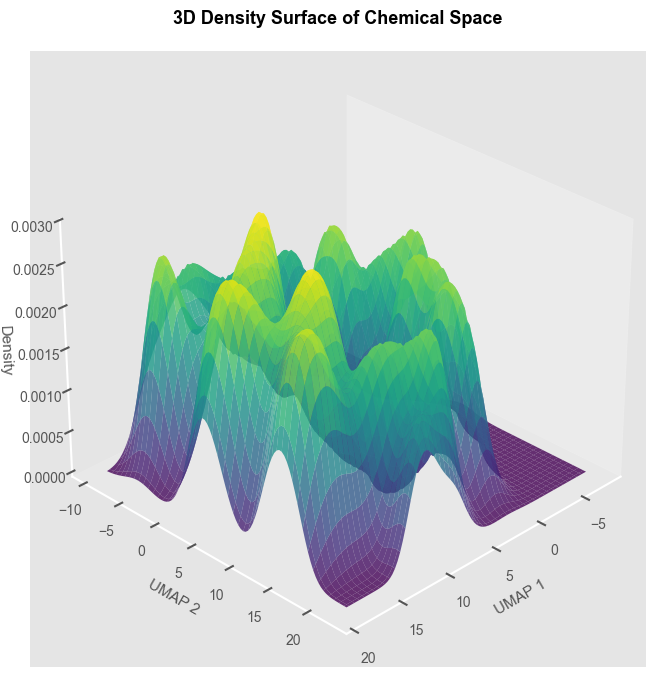

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D

# 1. Prepare Data
x = embedding[:, 0]
y = embedding[:, 1]

# 2. Calculate Kernel Density Estimation (KDE)
# This creates the "bivariate normal" heights
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# 3. Plotting (Object-Oriented)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(xi, yi, zi.reshape(xi.shape), 
                       cmap='viridis', 
                       edgecolor='none', 
                       alpha=0.8,
                       antialiased=True)

# Formatting
ax.set_title('3D Density Surface of Chemical Space', fontweight='bold', pad=20)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('Density')

# Clean up the view
ax.view_init(elev=30, azim=45) # Adjust angle to see the "hills"
ax.grid(False) # Cleaner look for papers
plt.show()